<a href="https://colab.research.google.com/github/vothane/tripleplay/blob/master/tripleplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
import numpy as np
import os.path
import warnings

warnings.filterwarnings('ignore')

Using TensorFlow backend.


Run this cell only if you do not already have the image data.

***Recommend that you not run this on your own machine.***

In [3]:
!git clone https://github.com/vothane/tripleplay.git
!mv tripleplay/imgs imgs
!rm -rf tripleplay
!ls

Cloning into 'tripleplay'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 140 (delta 22), reused 104 (delta 3), pack-reused 0
Receiving objects: 100% (140/140), 12.26 MiB | 30.17 MiB/s, done.
Resolving deltas: 100% (22/22), done.
imgs  sample_data


In [4]:
f = lambda img_file : img_to_array(load_img('imgs/{}'.format(img_file), color_mode = "grayscale"))
pitcher_map = {img_file[:-4] : f(img_file)
              for img_file in os.listdir('imgs/')}
print(np.shape(pitcher_map['Chris_Sale']))

(600, 600, 1)


In [5]:
image_size = 600 # x=y

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

W0708 21:43:40.564906 139895557216128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0708 21:43:40.636938 139895557216128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0708 21:43:40.639713 139895557216128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 600, 600, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1440000)           0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                23040016  
Total params: 23,058,832
Trainable params: 23,058,832
Non-trainable params: 0
_________________________________________________________________


In [6]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1440000)           24480000  
_________________________________________________________________
reshape_1 (Reshape)          (None, 150, 150, 64)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 300, 300, 64)      36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 600, 600, 32)      18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 600, 600, 1)       289       
Total params: 24,535,681
Trainable params: 24,535,681
Non-trainable params: 0
________________________________________________________________

In [7]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 600, 600, 1)       0         
_________________________________________________________________
encoder (Model)              (None, 16)                23058832  
_________________________________________________________________
decoder (Model)              (None, 600, 600, 1)       24535681  
Total params: 47,594,513
Trainable params: 47,594,513
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

train_data = np.array([data for _, data in pitcher_map.items()])

autoencoder.fit(train_data, train_data, epochs=15, batch_size=batch_size)

W0708 21:43:40.989797 139895557216128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0708 21:43:41.484253 139895557216128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0708 21:43:41.692300 139895557216128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/15
96/96 [==============================] - 70s 725ms/step - loss: 1379.3846
Epoch 2/15
96/96 [==============================] - 64s 667ms/step - loss: 1374.8311
Epoch 3/15
96/96 [==============================] - 65s 672ms/step - loss: 1374.7645
Epoch 4/15
96/96 [==============================] - 64s 671ms/step - loss: 1374.6735
Epoch 5/15
96/96 [==============================] - 64s 671ms/step - loss: 1374.5749
Epoch 6/15
96/96 [==============================] - 64s 667ms/step - loss: 1374.5334
Epoch 7/15
96/96 [==============================] - 65s 682ms/step - loss: 1374.5325
Epoch 8/15
96/96 [==============================] - 64s 669ms/step - loss: 1374.5374
Epoch 9/15
96/96 [==============================] - 64s 666ms/step - loss: 1374.5402
Epoch 10/15
96/96 [==============================] - 64s 665ms/step - loss: 1374.5433
Epoch 11/15
96/96 [==============================] - 64s 667ms/step - loss: 1374.5466
Epoch 12/15
96/96 [==============================] - 64s 662ms/

# Motivation for using tSNE

AI (hate that term) is neither good nor evil. But they do reflect on our society. Including social bias, unfairness and discrimination. Mostly unintentional, either by laziness or carelessness. Sometimes with malicious intent, for example ***Palantir***, the most perverse use of this technology.

I’m not going too much into the societal implications but will introduce some tools and strategies to weed out undesirable learning dynamics. 


In [9]:
from sklearn.manifold import TSNE

deep_features = encoder.predict(train_data, batch_size=batch_size)

tsne  = TSNE(n_components=2)
X_embedded = tsne.fit_transform(deep_features)
tsne.fit_transform(deep_features[1].reshape(-1, 1))
X_embedded

array([[  2.1756532 ,   3.780999  ],
       [ -0.9629193 ,  -5.0637975 ],
       [  2.3900924 ,   4.7689414 ],
       [ -1.9009707 ,  -8.356439  ],
       [  1.5804801 ,   2.5990674 ],
       [  3.372379  ,   5.9903316 ],
       [  0.71784884,  -0.44412756],
       [ -1.3918715 ,  -7.13121   ],
       [ -2.1081195 ,  -8.122495  ],
       [  1.7081832 ,   0.92416716],
       [  1.9829018 ,   1.694835  ],
       [  2.498152  ,   4.102324  ],
       [  1.2058026 ,   0.10326362],
       [  3.5289288 ,   6.2085147 ],
       [  2.0505362 ,   2.8669403 ],
       [ -2.5146804 ,  -9.611163  ],
       [ -1.7814468 ,  -7.5393806 ],
       [  2.7520752 ,   4.007734  ],
       [ -1.5711749 ,  -6.8446403 ],
       [  2.4737437 ,   2.7550254 ],
       [ -1.9325823 ,  -7.897701  ],
       [ -1.2273284 ,  -5.6515446 ],
       [ -0.80071026,  -5.947479  ],
       [  2.0963218 ,   3.2018857 ],
       [  2.1482227 ,   1.9837459 ],
       [  0.15263923,  -2.8778882 ],
       [ -0.02179938,  -2.9809134 ],
 

Really this is basically nearest neighbors where closet points are pitchers who closely resemble each other. I need to
graph these points and label them with pitchers names to make sense of it all. after that we can ascertain what these 
deep features may be, right now there are 16 and we can use ensemble algos to find an optimal number after words. i'm guessing something like arm slot (3/4 or overhand) and left/right handedness. 

At second glance, features like arm slot (3/4 or overhand) and left/right handedness are actually linear regression features and should be learned at the topmost hidden layer. This is apparent by visual inspection, where data points can be "regressed" with straight diagonal line. \ line would indicate right-handed pitcher and / would be "southpaws". Whereas angle of the line indicates arm-slot.

Having said this, these simple features should still be inherent in non-linear complex features found in deeper hidden layers. For example, fastballs that have movement couldn't be linear regress by location, but should still be in the same region corresponding to pitching hand and arm slot.

Use K-Means clustering to see how many types of pitchers (categories) we have.

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(random_state=0).fit(X_embedded)
len(kmeans.cluster_centers_)

8

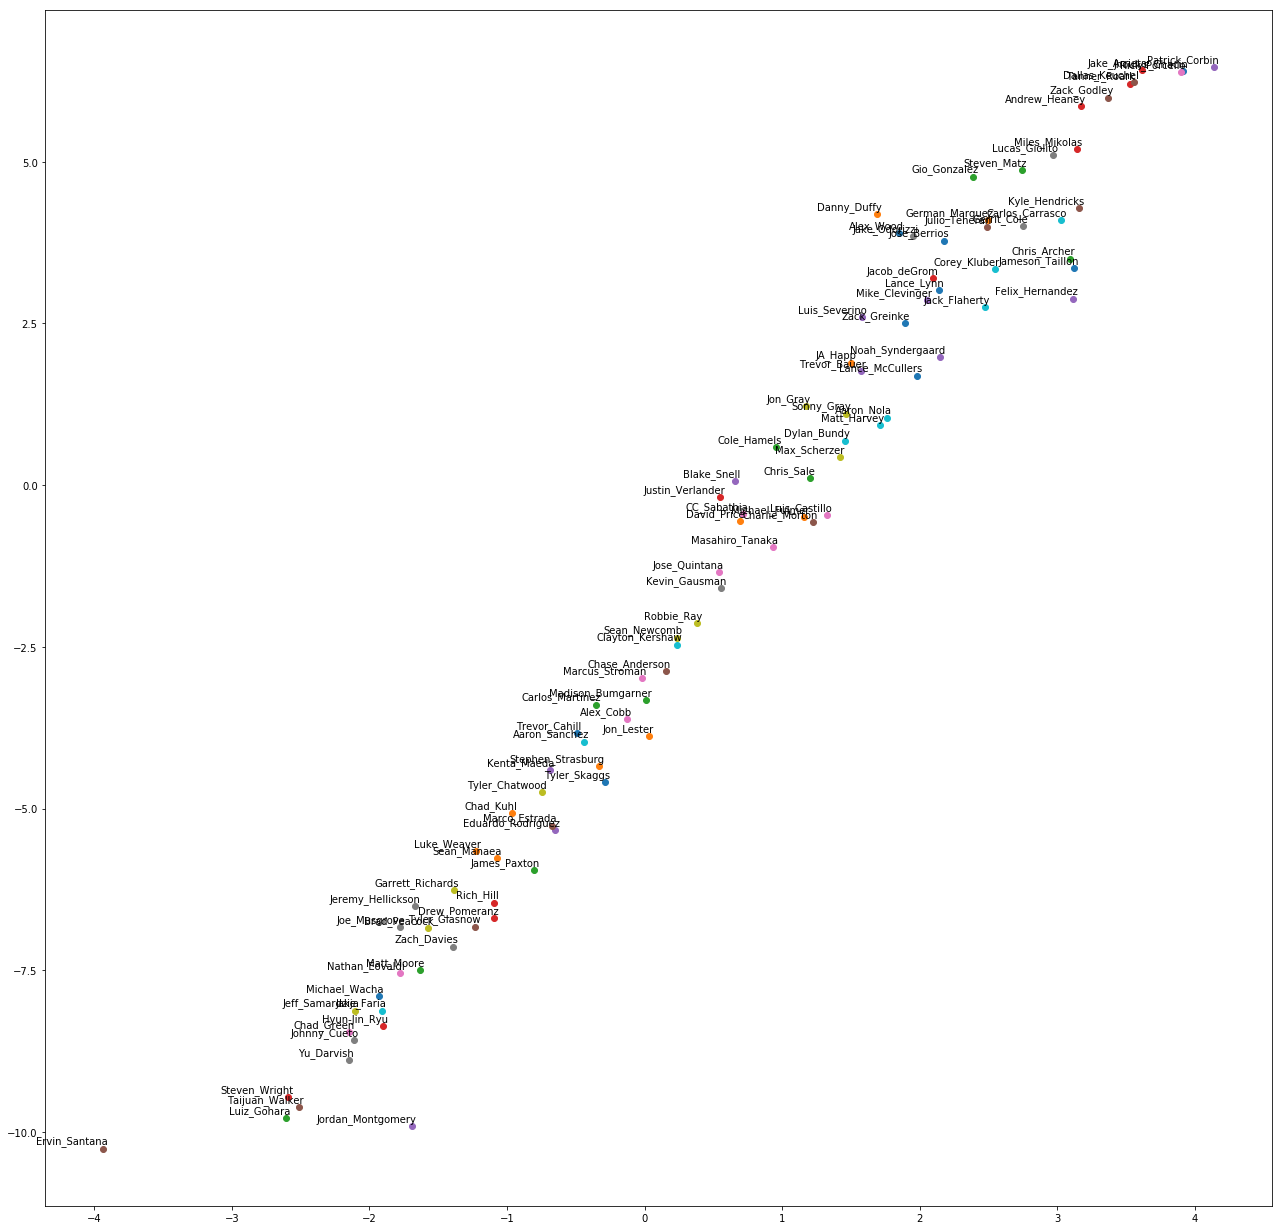

In [11]:
import matplotlib.pyplot as plt

names = np.array([pitcher for pitcher, _ in pitcher_map.items()])

x = []
y = []

for value in X_embedded:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(22, 22))    

for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(names[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
     
plt.show()

### Note tSNE does not oriented data to any prescribed axis on the graph. Evertime it is runned the graph may flip on either the x or y axis.

### It may seem like we are plotting two variables where *x* is independent and *y* is dependent such that there exists a function 

\begin{align}
f(x)=y
\end{align}

### This is not the case. This is two independent variables with a correlating linear relationship. This linear relationship is an approximation of the identity function which autoencoders suppose to do. But not model the identity function perfectly which is overfitting and not what we want. If it did overfit the model will make not learn any *conceptual generalizations* from the  data, just memorize mappings of input to output.  Analogous to hacking a professors computer to get answers to a midterm and not studying to learn the material. Come test time the questions on midterm was changed because the professor found out the computer was hacked. Not saying I ever did such a thing $_{cough}$ $_{cough}$.

### Since the points don't fall exactly in a straight line, I'm confiident we are not overfitting. 


\begin{align}
\text{ identity function ala autoencoder} \\
g(f(x))=x \\
\text{where $f$ is the encoder} \\
\text{and $g$ is the decoder} \\
\text{note that we took the encoder $f$ to find deep features $z$} \\
\text{moreover $f(x)=z$}
\end{align}